In [1]:
%load_ext rich

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
from tsa import settings
from tsa.database.connector import Connector
from tsa.database.repositories import ObservationRepository, StationRepository

In [4]:
connector = Connector(settings=settings.db)

In [5]:
with connector.get_session() as session:
    observation_repository = ObservationRepository(session=session)
    station_repository = StationRepository(session=session)
    station = station_repository.get_by_code(code=settings.station)
    if not station:
        raise ValueError(f"Station with code {settings.station} not found.")
    station_id = station.id
    if not station_id:
        raise ValueError(f"Station ID for code {settings.station} is None.")
    results = observation_repository.find_for_station(station_id=station_id)
    data = list(map(dict, results))
    df = (
        pd.DataFrame(data)
        .assign(datetime=lambda df_: pd.to_datetime(df_["datetime"]))
        .set_index("datetime")
        .asfreq("h")
    )

In [6]:
selected_columns = [
    column
    for column in df.columns
    if column not in ["id", "station_id", "created_at", "updated_at"]
]

In [7]:
width, height = plt.rcParams["figure.figsize"]

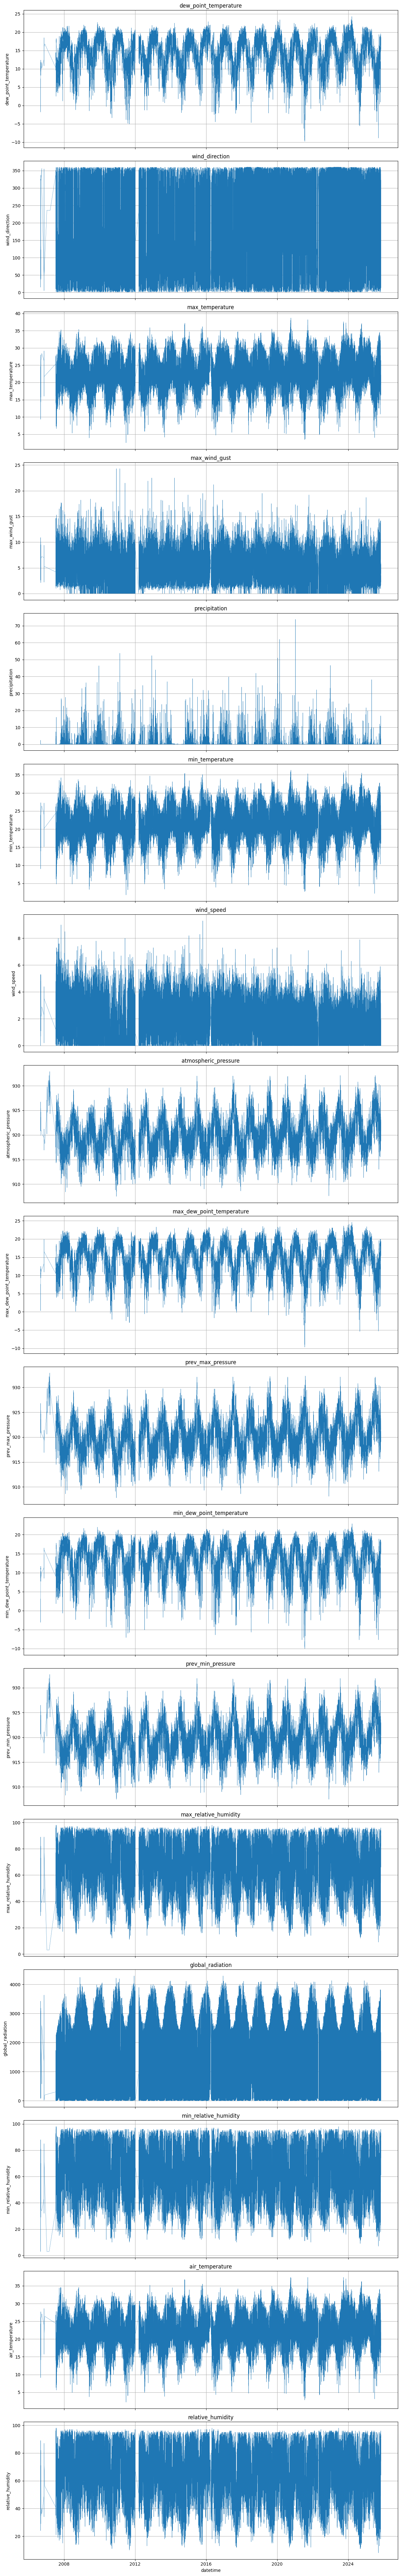

In [8]:
fig, axes = plt.subplots(
    len(selected_columns), 1,
    figsize=(2 * width, height * len(selected_columns)),
    sharex=True,
)

for ax, column in zip(axes, selected_columns):
    sns.lineplot(data=df, x=df.index, y=column, linewidth=0.4,  ax=ax)
    ax.set_title(column)
    ax.set_xlabel("datetime")
    ax.set_ylabel(column)
    ax.grid(True)

fig.tight_layout()
fig.savefig("series.png")